# Regression

In [1]:
#Import the necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read the data
!wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

--2025-10-07 00:00:55--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘car_fuel_efficiency.csv.13’

car_fuel_efficiency 100%[===================>] 853.70K  --.-KB/s    in 0.008s  

2025-10-07 00:00:55 (102 MB/s) - ‘car_fuel_efficiency.csv.13’ saved [874188/874188]



In [3]:
# load the data into a dataframe
df = pd.read_csv("car_fuel_efficiency.csv")

In [4]:
# see the first few columns of the data
df.head()

engine_displacement  num_cylinders  horsepower  vehicle_weight  \
0                  170            3.0       159.0     3413.433759   
1                  130            5.0        97.0     3149.664934   
2                  170            NaN        78.0     3079.038997   
3                  220            4.0         NaN     2542.392402   
4                  210            1.0       140.0     3460.870990   

   acceleration  model_year  origin fuel_type         drivetrain  num_doors  \
0          17.7        2003  Europe  Gasoline    All-wheel drive        0.0   
1          17.8        2007     USA  Gasoline  Front-wheel drive        0.0   
2          15.1        2018  Europe  Gasoline  Front-wheel drive        0.0   
3          20.2        2009     USA    Diesel    All-wheel drive        2.0   
4          14.4        2009  Europe  Gasoline    All-wheel drive        2.0   

   fuel_efficiency_mpg  
0            13.231729  
1            13.688217  
2            14.246341  
3            16.912736  
4            12.488369

In [5]:
# Data preparation
# unify the column names
df.columns = df.columns.str.lower().str.replace(' ','_')

#unify the non-nummerical data series
string_features = list(df.dtypes[df.dtypes == object].index)
for col in string_features:
    df[col] = df[col].str.lower().str.replace(' ','_')



In [6]:
# Explore the data
# see unique values in the data
columns = list(df.columns)
for col in columns:
    print(col)
    print(df[col].unique()[:5])
    print(df[col].nunique())
    
# select base features to use as baseline
base_feat = ['engine_displacement', 'horsepower', 'vehicle_weight', 'model_year', 'fuel_efficiency_mpg']
df_base = df[base_feat]

engine_displacement
[170 130 220 210 190]
36
num_cylinders
[ 3.  5. nan  4.  1.]
14
horsepower
[159.  97.  78.  nan 140.]
192
vehicle_weight
[3413.43375861 3149.66493422 3079.03899737 2542.39240183 3460.87098999]
9704
acceleration
[17.7 17.8 15.1 20.2 14.4]
162
model_year
[2003 2007 2018 2009 2008]
24
origin
['europe' 'usa' 'asia']
3
fuel_type
['gasoline' 'diesel']
2
drivetrain
['all-wheel_drive' 'front-wheel_drive']
2
num_doors
[ 0.  2. -1.  1. nan]
9
fuel_efficiency_mpg
[13.23172891 13.68821744 14.246341   16.9127356  12.48836912]
9704


<Axes: xlabel='fuel_efficiency_mpg', ylabel='Count'>

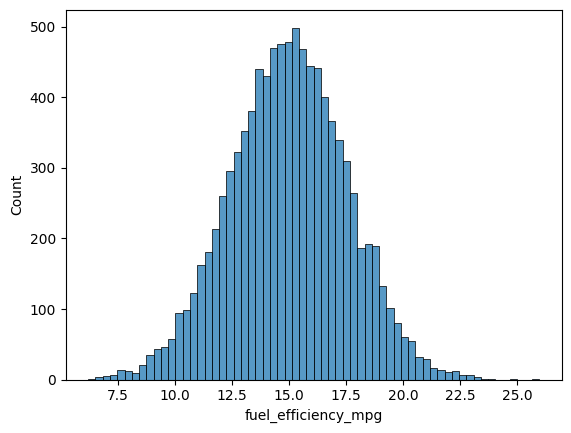

In [7]:
# Looking at the distribution of fuel_efficiency_mpg
sns.histplot(df['fuel_efficiency_mpg'])

In [8]:
# Q1: To find the column with missing values
df_base.isnull().sum()[df_base.isnull().sum() !=0]

horsepower    708
dtype: int64

In [9]:
# Q2: The median of horsepower
df_base['horsepower'].median()

np.float64(149.0)

In [10]:
# Prepare and split the data

# Get the total length of the data
n = len(df_base)
n

9704

In [11]:
# specify amount of data to be contained in train, validation, and test sets using 60%/20%/20% respectively
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
n_train, n_val, n_test

(5824, 1940, 1940)

In [12]:
# Generate a range to be shuffled with seed 42
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)
idx

array([ 483, 7506, 8795, ..., 5390,  860, 7270], shape=(9704,))

In [13]:
# Split the data set with the random shuffled indices
df_train = df_base.iloc[ idx[:n_train] ]
df_val = df_base.iloc[ idx[n_train : n_train + n_val] ]
df_test = df_base.iloc[ idx[n_train + n_val : ] ]
len(df_train), len(df_val), len(df_test)

(5824, 1940, 1940)

In [14]:
# Split also the target feature
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values
len(y_train), len(y_val), len(y_test)

(5824, 1940, 1940)

In [15]:
del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

In [16]:
# Prepare feature matrix by filling NaNs with zero
def prepare_feature_matrix_zerofill(df):
    df = df.copy()
    X = df.fillna(0).values
    return X

# Prepare feature matrix by filling NaNs with mean value of the column with missing values
def prepare_feature_matrix_meanfill(df):
    df = df.copy()
    X = df.fillna(df_train['horsepower'].mean()).values
    return X

X_train_zerofill = prepare_feature_matrix_zerofill(df_train)
X_train_meanfill = prepare_feature_matrix_meanfill(df_train)

In [17]:
# Train linear regression model
def train_linear_regression(X_train, y_train):
    # append a column of ones to the left of the feature matrix
    ones = np.ones(X_train.shape[0])
    X = np.column_stack([ones, X_train])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y_train)
    return w

# Q3: check whether X_train_zerofill or X_train_meanfill gives the better rmse
w = train_linear_regression(X_train_zerofill, y_train)

X_val = prepare_feature_matrix_zerofill(df_val)
y_pred = w[0] + X_val.dot(w[1:])

# Root-mean-square-error RMSE
def rmse(y, y_pred):
    SE = (y - y_pred)**2 # square error
    MSE = np.mean(SE)
    return np.sqrt(MSE)

score = rmse(y_val, y_pred)
round(score,2)

np.float64(0.52)

In [18]:
# Using X_train_meanfill to see the rmse
w = train_linear_regression(X_train_meanfill, y_train)

X_val = prepare_feature_matrix_zerofill(df_val)
y_pred = w[0] + X_val.dot(w[1:])

# Root-mean-square-error RMSE
def rmse(y, y_pred):
    SE = (y - y_pred)**2 # square error
    MSE = np.mean(SE)
    return np.sqrt(MSE)

score = rmse(y_val, y_pred)
round(score,2)

np.float64(0.61)

In [19]:
# Train linear regression model with regularization

def train_regularized_linear_regression(X_train, y_train, r):
    #append a column of ones to the left of the feature matrix
    ones = np.ones(X_train.shape[0])
    X = np.column_stack([ones, X_train])
    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])
    XTX_inv = np.linalg.inv(XTX)
    w = XTX_inv.dot(X.T).dot(y_train)
    return w

r = 0.1
w = train_regularized_linear_regression(X_train_zerofill, y_train, r)
X_val = prepare_feature_matrix_zerofill(df_val)
y_pred = w[0] + X_val.dot(w[1:])

score = rmse(y_val, y_pred)
round(score,2)

np.float64(0.52)

In [20]:
# Q4: Checking diffrent values of the regularizaton paramter
r_set = [0, 0.01, 0.1, 1, 5, 10, 100]

for r in r_set:
    X_train = prepare_feature_matrix_zerofill(df_train)
    w = train_regularized_linear_regression(X_train, y_train, r)
    X_val = prepare_feature_matrix_zerofill(df_val)
    y_pred = w[0] + X_val.dot(w[1:])
    score = rmse(y_val, y_pred)
    print(r, w[0], round(score,2))


0 28.827365475106156 0.52
0.01 24.92683842008767 0.52
0.1 11.239661084961272 0.52
1 1.7315979411936366 0.52
5 0.3638075020692219 0.52
10 0.18306246622306527 0.52
100 0.018418017306977234 0.52


In [21]:
# Q5: Impact of different random seeds
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
score = np.zeros(len(seeds))

for seed in seeds:
    idx = np.arange(n)
    np.random.seed(seed)
    np.random.shuffle(idx)
    
    # Split the data set with the random shuffled indices
    df_train = df_base.iloc[ idx[:n_train] ]
    df_val = df_base.iloc[ idx[n_train : n_train + n_val] ]
    df_test = df_base.iloc[ idx[n_train + n_val : ] ]
    
    # Split also the target feature
    y_train = df_train['fuel_efficiency_mpg'].values
    y_val = df_val['fuel_efficiency_mpg'].values
    y_test = df_test['fuel_efficiency_mpg'].values
    len(y_train), len(y_val), len(y_test)
    
    del df_train['fuel_efficiency_mpg']
    del df_val['fuel_efficiency_mpg']
    del df_test['fuel_efficiency_mpg']

    X_train = prepare_feature_matrix_zerofill(df_train)
    w = train_linear_regression(X_train, y_train)
    X_val = prepare_feature_matrix_zerofill(df_val)
    y_pred = w[0] + X_val.dot(w[1:])
    score[seed] = rmse(y_val, y_pred)

score

array([0.52065313, 0.52133889, 0.522807  , 0.51595167, 0.51091295,
       0.52834065, 0.53139107, 0.50906704, 0.51473991, 0.51318659])

In [22]:
# standard deviation of the scores

std = np.std(score)
round(std,3)

np.float64(0.007)

In [23]:
# Q6: Using the model combining training and validation data
# concatenate df_train and df_val, then y_train and y_val
# Use random seed value of 9 and regularization parametre value of 0.001
r = 0.001
idx = np.arange(n)
np.random.seed(9)
np.random.shuffle(idx)

# Split the data set with the random shuffled indices
df_train = df_base.iloc[ idx[:n_train] ]
df_val = df_base.iloc[ idx[n_train : n_train + n_val] ]
df_test = df_base.iloc[ idx[n_train + n_val : ] ]

# Split also the target feature
y_train = df_train['fuel_efficiency_mpg'].values
y_val = df_val['fuel_efficiency_mpg'].values
y_test = df_test['fuel_efficiency_mpg'].values

del df_train['fuel_efficiency_mpg']
del df_val['fuel_efficiency_mpg']
del df_test['fuel_efficiency_mpg']

# Concatenate df_train and df_val
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

# Concatenate y_train and y_val
y_full_train = np.concatenate([y_train, y_val])

X_full_train = prepare_feature_matrix_zerofill(df_full_train)
w = train_regularized_linear_regression(X_full_train, y_full_train, r)
X_test = prepare_feature_matrix_zerofill(df_test)
y_pred = w[0] + X_test.dot(w[1:])
score = rmse(y_test, y_pred)
score


np.float64(0.5156261299167999)